In [43]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt 
from numpy.fft import fft2, ifft2, fftshift, ifftshift

The following sub-routine is for displaying the images

In [44]:
def display_image(image,title):
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

The following sub-routine is for computing the structural similarity index between two images
The value range is between 0 to 1
where 1 : Perfectly similar 
where 0: completely different

So, a high SSIM score indicate that the images are very very similar and a low score would indicate that some alterations have been done

In [45]:
def compute_ssim(image1, image2):
    # Compute SSIM between two grayscale images
    ssim_score, _ = ssim(image1, image2, full=True)
    return ssim_score

The following sub-routine is for finding the Fast Fourier Transformation Magnitude Spectrum Difference where 
0: no difference in the frequencyy domain
Higher Values: some changes or significant changes in frequency components

The reason for checking this is to find whether some changes have been made to the image, say
1. smoothing
2. filtering
3. sharpening
4. some geometric transformation
5. corruption, erosion 

In [46]:
def fft_analysis(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f = fft2(gray)
    fshift = fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('FFT Magnitude Spectrum')
    plt.axis('off')
    plt.show()
    
    print("Max magnitude in FFT:", np.max(magnitude_spectrum))
    print("Mean magnitude in FFT:", np.mean(magnitude_spectrum))
    
    return fshift, magnitude_spectrum

The following sub-routine is for edge detection where we identify the boundaries in an image which could tell us whether an image has undergone smoothing or sharpening.

In [53]:
def edge_detection(image):
    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    

    edges = cv2.Canny(gray, 100, 200)
    

    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')
    plt.show()
    
    return edges


def edge_difference(image1, image2):
    # Perform edge detection on both images
    edges1 = edge_detection(image1)
    edges2 = edge_detection(image2)

    # Resize edges to the same size if necessary
    edges2_resized = cv2.resize(edges2, (edges1.shape[1], edges1.shape[0]))

    # Calculate Mean Squared Error between the edge images
    mse = np.mean((edges1.astype("float") - edges2_resized.astype("float")) ** 2)
    
    return mse

The following sub-routine is for checking whether there are any geometric transformations where 
less number of keypoints would suggest that the image has undergone geometric transformations.

In [48]:
def detect_transformations(image1, image2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    img_matches = cv2.drawMatches(image1, kp1, image2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    display_image(img_matches, 'Keypoint Matches (for Geometric Transformation Detection)')
    
    print(f"Number of Matches: {len(matches)}")
    print(f"Mean Match Distance: {np.mean([m.distance for m in matches])}")
    
    return matches

The following sub-routine will perform all the above sub-routines and then show the results

In [49]:
def detect_transformations_and_changes(original_image, suspected_image):
    print("--- Original Image ---")
    display_image(original_image, "Original Image")
    
    print("--- Suspected Image ---")
    display_image(suspected_image, "Suspected Image")
    
    print("--- SSIM Structural Similarity ---")
    # Convert images to grayscale for SSIM computation
    gray_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray_suspected = cv2.cvtColor(suspected_image, cv2.COLOR_BGR2GRAY)
    
    ssim_score = compute_ssim(gray_original, gray_suspected)
    
    print("--- FFT Analysis ---")
    fft_orig, fft_orig_mag = fft_analysis(original_image)
    fft_suspected, fft_suspected_mag = fft_analysis(suspected_image)
    
    fft_diff = np.mean(np.abs(fft_orig_mag - fft_suspected_mag))
    print(f"Mean FFT Magnitude Difference: {fft_diff}")
    
    print("--- Edge Detection ---")
    edge_orig = edge_detection(original_image)
    edge_suspected = edge_detection(suspected_image)
    
    edge_diff = edge_difference(edge_orig, edge_suspected)
    
    print("--- Detecting Geometric Transformations ---")
    matches = detect_transformations(original_image, suspected_image)
    
    return {
        "ssim_score": ssim_score,
        "fft_diff": fft_diff,
        "edge_diff": edge_diff,
        "geometric_matches": len(matches)
    }


The following sub-routine will perform a routine where it will check whether a given image is real or some plagiarised image.

In [50]:
def is_image_real(ssim_score, fft_diff, edge_diff, geometric_matches):
    SSIM_THRESHOLD = 0.85        
    FFT_DIFF_THRESHOLD = 20.0    
    EDGE_DIFF_THRESHOLD = 10.0   
    GEOMETRIC_MATCH_THRESHOLD = 15  
    
    if ssim_score < SSIM_THRESHOLD:
        print("Conclusion: Image is likely plagiarized due to low structural similarity (SSIM).")
        return "Plagiarized"
    
    if fft_diff > FFT_DIFF_THRESHOLD:
        print("Conclusion: Image has undergone frequency modifications (blurring, filtering, sharpening).")
        return "Plagiarized"
    
    if edge_diff > EDGE_DIFF_THRESHOLD:
        print("Conclusion: Image has been sharpened or smoothed.")
        return "Plagiarized"
    
    if geometric_matches < GEOMETRIC_MATCH_THRESHOLD:
        print("Conclusion: Image has undergone geometric transformations (rotation, scaling, etc.).")
        return "Plagiarized"
    
    print("Conclusion: Image is likely real (not significantly altered).")
    return "Real"


In [51]:
def resize_image(image, size=(1024, 1024)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

actual main code ...

--- Original Image ---


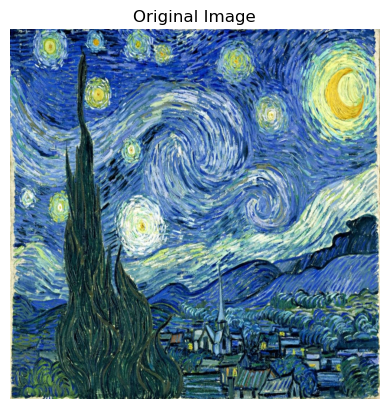

--- Suspected Image ---


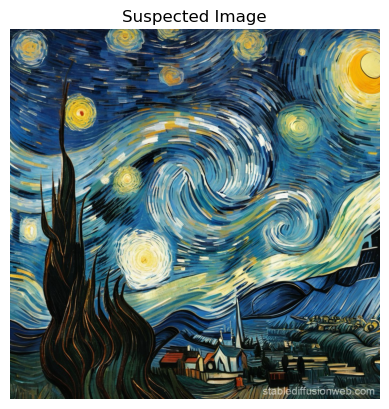

--- SSIM Structural Similarity ---
--- FFT Analysis ---


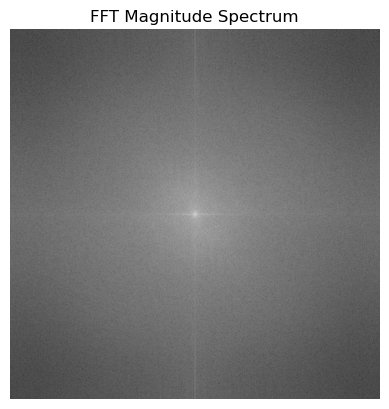

Max magnitude in FFT: 370.97916118609197
Mean magnitude in FFT: 175.27064574082308


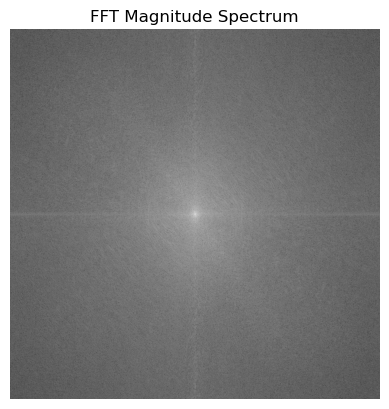

Max magnitude in FFT: 367.94448333810465
Mean magnitude in FFT: 181.61541679177574
Mean FFT Magnitude Difference: 16.314150754023597
--- Edge Detection ---


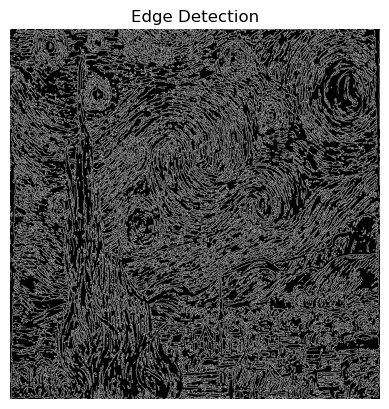

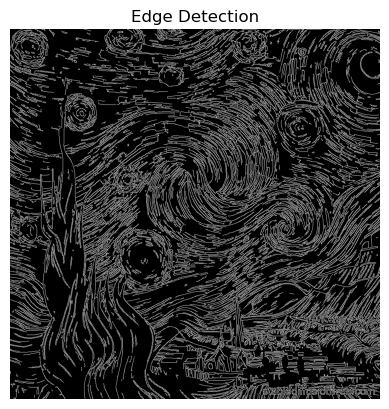

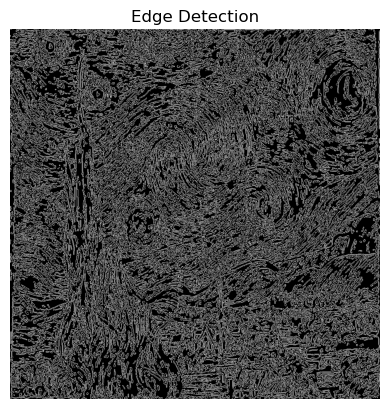

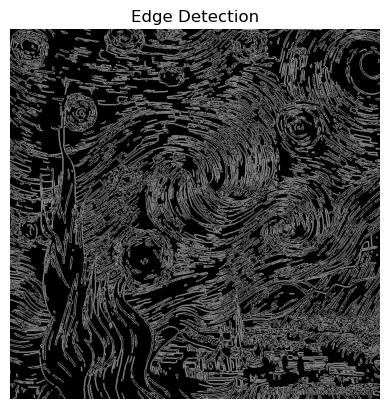

--- Detecting Geometric Transformations ---


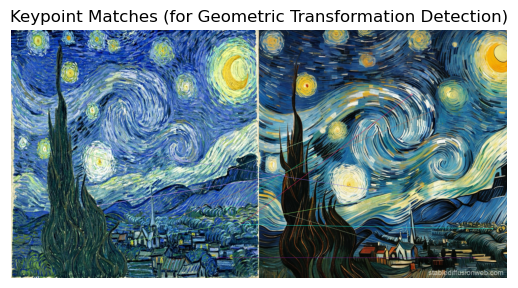

Number of Matches: 171
Mean Match Distance: 68.19883040935673
Conclusion: Image is likely plagiarized due to low structural similarity (SSIM).
Final Decision: The image is Plagiarized.


In [54]:
if __name__ == '__main__':
    original_image = cv2.imread('/Users/lokeshbudda/Desktop/DIP/Image-plagiarism-Checker/Vincent_van_Gogh_368.jpg') 
    suspected_image = cv2.imread('/Users/lokeshbudda/Desktop/DIP/Image-plagiarism-Checker/image.png') 
    original_image_resized = resize_image(original_image)
    suspected_image_resized = resize_image(suspected_image)
    results = detect_transformations_and_changes(original_image_resized, suspected_image_resized)
    
    final_decision = is_image_real(
        ssim_score=results['ssim_score'], 
        fft_diff=results['fft_diff'], 
        edge_diff=results['edge_diff'], 
        geometric_matches=results['geometric_matches']
    )

    print(f"Final Decision: The image is {final_decision}.")
